# Part 1: 
In your project you have been working with a bias dataset. Most probabely suupervised models were underfit. You should remember that this is a real dataset, and in real life most of the time you dont have access to clean and unbias dataset. In situations like this, none of the regression models will have a good fit for the dataset due to the large predence of the 0s. In the first part of this take-home exam, you are asked to be creative, and find a solution for this problem. 

For this dataset, you can break the problem, into a two-step machine learning model. 

First step is to classify the data points as positive revenue and zero revenue. This simply is a binary classification. You should remember that when you are dealing with biased datasets, accuracy is not a reliable scoring metric. So look for a robust scoring function. 

Next, you need to build a regression model to postprocess classification results. Here is a flow chart to show you the outline of the model. 

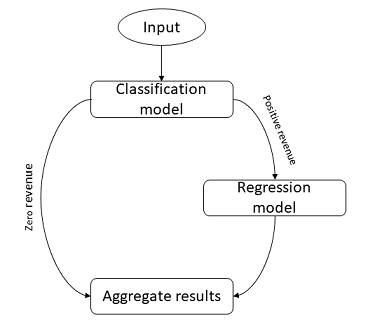

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Import matplotlib & seaborn for visualisation
import simplejson as json
from pandas.io.json import json_normalize
import seaborn as sns 
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
import numpy as np
init_notebook_mode(connected=True)
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
import missingno as msno
import ast

In [2]:
data=pd.read_csv('data.csv')

In [3]:
empty=[]
for index,row in data['customDimensions'].iteritems():
    #row2 = ast.literal_eval(row)
    row1=row.replace('[]',"{'index': 'None', 'value': 'None'}")
    row2=row1.replace('[','')
    row3=row2.replace(']','')
    row4=ast.literal_eval(row3)
    #row5 = ast.literal_eval(row3)
    empty.append(row4)
data.drop('customDimensions',axis=1,inplace=True)
empty_df = pd.DataFrame(empty)
data=data.merge(empty_df, right_index=True, left_index=True)
data

,channelGrouping,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,trafficSource,visitId,visitNumber,...,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue,totals_transactions,totals_visits,index,value
0,Organic Search,20171016,{'mobileDeviceInfo': 'not available in demo da...,3162355547410993243,"{'cityId': 'not available in demo dataset', 'm...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{'campaign': '(not set)', 'source': 'google', ...",1508198450,1,...,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1,4,EMEA
1,Referral,20171016,{'mobileDeviceInfo': 'not available in demo da...,8934116514970143966,"{'cityId': 'not available in demo dataset', 'm...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,{'referralPath': '/a/google.com/transportation...,1508176307,6,...,NaN,2.0,2.0,28.0,NaN,NaN,NaN,1,4,North America
2,Direct,20171016,{'mobileDeviceInfo': 'not available in demo da...,7992466427990357681,"{'cityId': 'not available in demo dataset', 'm...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{'isTrueDirect': True, 'campaign': '(not set)'...",1508201613,1,...,1.0,2.0,1.0,38.0,NaN,NaN,NaN,1,4,North America
3,Organic Search,20171016,{'mobileDeviceInfo': 'not available in demo da...,9075655783635761930,"{'cityId': 'not available in demo dataset', 'm...","[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,"{'campaign': '(not set)', 'source': 'google', ...",1508169851,1,...,1.0,2.0,1.0,1.0,NaN,NaN,NaN,1,4,EMEA
4,Organic Search,20171016,{'mobileDeviceInfo': 'not available in demo da...,6960673291025684308,"{'cityId': 'not available in demo dataset', 'm...","[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,"{'campaign': '(not set)', 'source': 'google', ...",1508190552,1,...,1.0,2.0,1.0,52.0,NaN,NaN,NaN,1,4,Central America
5,Referral,20171016,{'mobileDeviceInfo': 'not available in demo da...,166277907528479249,"{'cityId': 'not available in demo dataset', 'm...","[{'hitNumber': '1', 'time': '0', 'hour': '16',...",Not Socially Engaged,"{'referralPath': '/offer/2145', 'campaign': '(...",1508196701,1,...,1.0,2.0,2.0,12.0,NaN,NaN,NaN,1,4,North America
6,Referral,20171016,{'mobileDeviceInfo': 'not available in demo da...,8349655975937271469,"{'cityId': 'not available in demo dataset', 'm...","[{'hitNumber': '1', 'time': '0', 'hour': '4', ...",Not Socially Engaged,{'referralPath': '/a/google.com/nest-vision/dr...,1508152478,1,...,1.0,2.0,1.0,9.0,NaN,NaN,NaN,1,4,EMEA
7,Organic Search,20171016,{'mobileDeviceInfo': 'not available in demo da...,1332629902468998662,"{'cityId': 'not available in demo dataset', 'm...","[{'hitNumber': '1', 'time': '0', 'hour': '19',...",Not Socially Engaged,"{'campaign': '(not set)', 'source': 'google', ...",1508206208,1,...,1.0,2.0,1.0,15.0,NaN,NaN,NaN,1,None,None
8,Organic Search,20171016,{'mobileDeviceInfo': 'not available in demo da...,632878546807742341,"{'cityId': 'not available in demo dataset', 'm...","[{'hitNumber': '1', 'time': '0', 'hour': '19',...",Not Socially Engaged,"{'campaign': '(not set)', 'source': 'google', ...",1508207516,1,...,1.0,2.0,1.0,34.0,NaN,NaN,NaN,1,4,Central America
9,Organic Search,20171016,{'mobileDeviceInfo': 'not available in demo da...,1259490915281096752,"{'cityId': 'not available in demo dataset', 'm...","[{'hitNumber': '1', 'time': '0', 'hour': '7', ...",Not Socially Engaged,"{'isTrueDirect': True, 'campaign': '(not set)'...",1508165159,2,...,NaN,2.0,1.0,32.0,NaN,NaN,NaN,1,4,EMEA


In [4]:
def todict(dic, key, value):
    if key in dic:
        dic[key].append(value)
    else:
        dic[key] = [value]
    return dic


def resolve_json(hitsdic, hits_json, key='NoneName'):
    if type(hits_json) == list:
        if len(hits_json) == 0:
            pass
        else:
            for subjson in hits_json:
                hitsdic = resolve_json(hitsdic, subjson)
    elif type(hits_json) == dict:
        for i in hits_json.keys():
            hitsdic = resolve_json(hitsdic, hits_json[i],i)
    else:
        hitsdic = todict(hitsdic, key, hits_json)
    return hitsdic


def complex_replace(x):
    dic = {}
    return resolve_json(dic, json.loads(x.replace('\'','\"'). \
                                        replace('TRUE','true'). \
                                        replace('True','true'). \
                                        replace('FALSE','false'). \
                                        replace('False','false'). \
                                        replace(', \"',', !&~'). \
                                        replace('\", ','!&~, '). \
                                        replace('\": ','!&~: '). \
                                        replace(': \"',': !&~'). \
                                        replace(' {\"',' {!&~'). \
                                        replace('\"}, ','!&~}, '). \
                                        replace('[{\"','[{!&~'). \
                                        replace('\"}]','!&~}]'). \
                                        replace('\"','_'). \
                                        replace('!&~','\"'). \
                                        encode('gbk','ignore'). \
                                        decode('utf-8','ignore'). \
                                        replace('\\','')))


def replace(x):
    return  json.loads(x.replace('\'','\"').replace('False', 'false').replace('True'))

In [5]:
def dict_to_columns(dataframe,column_name):
    df = dataframe.copy()
    df[column_name] = df[column_name].apply(lambda x: ast.literal_eval(x))
    new_dataframe = df[column_name].apply(pd.Series)
    dataframe.drop(columns = column_name)
    return new_dataframe

In [6]:
dict_names = ['device', 'geoNetwork', 'trafficSource']

#Iterate through each of the columns containing dictionary elements and convert them to columns
for name in dict_names:
    dict_df = dict_to_columns(data,name)
    data = pd.concat([data,dict_df],axis = 1)

#Droping dict columns after they have been converted
data = data.drop(columns = dict_names);

In [7]:
data=data.drop(columns = 'adwordsClickInfo')

In [8]:
hits_columns = json_normalize(data['hits'].apply(complex_replace))
hits_columns.head(3)

,action_type,affiliation,contentGroup1,contentGroup2,contentGroup3,contentGroup4,contentGroup5,contentGroupUniqueViews1,contentGroupUniqueViews2,contentGroupUniqueViews3,...,step,time,transactionCoupon,transactionId,transactionRevenue,transactionShipping,transactionTax,type,v2ProductCategory,v2ProductName
0,[0],NaN,[(not set)],[Bags],[(not set)],[(not set)],[(not set)],NaN,[1],NaN,...,[1],[0],NaN,NaN,NaN,NaN,NaN,[PAGE],"[Home/Drinkware/Water Bottles and Tumblers/, H...","[Google 17oz Stainless Steel Sport Bottle, 26 ..."
1,"[0, 0]",NaN,"[(not set), (not set)]","[(not set), (not set)]","[(not set), (not set)]","[(not set), (not set)]","[(not set), (not set)]",NaN,NaN,NaN,...,"[1, 1]","[0, 27844]",NaN,NaN,NaN,NaN,NaN,"[PAGE, PAGE]","[(not set), (not set), (not set), (not set), (...",[Google Men_s 100% Cotton Short Sleeve Hero Te...
2,"[0, 0]",NaN,"[(not set), (not set)]","[(not set), Apparel]","[(not set), (not set)]","[(not set), (not set)]","[(not set), (not set)]",NaN,[1],NaN,...,"[1, 1]","[0, 38153]",NaN,NaN,NaN,NaN,NaN,"[PAGE, PAGE]","[Home/Apparel/Kid_s/, Home/Apparel/Kid_s/, Hom...","[Google Toddler Short Sleeve Tee Red, Google Y..."


In [9]:
hits_columns=hits_columns.fillna(0)
cols=['transactionRevenue','transactionTax','transactionShipping','productRevenue']
l =pd.DataFrame()
for i in hits_columns['transactionTax']:
        if i !=0 :
            l=l.append(pd.DataFrame({cols[1]: i[0]}, index=[0]), ignore_index=True)
        else:
            l=l.append(pd.DataFrame({cols[1]: 0}, index=[0]), ignore_index=True)

In [10]:
l2=pd.DataFrame()
for i in hits_columns['transactionRevenue']:
        if i !=0 :
            l2=l2.append(pd.DataFrame({cols[0]: i[0]}, index=[0]), ignore_index=True,sort=True)
        else:
            l2=l2.append(pd.DataFrame({cols[0]: 0}, index=[0]), ignore_index=True,sort=True)


In [11]:
l3=pd.DataFrame()
for i in hits_columns['transactionShipping']:
        if i !=0 :
            l3=l3.append(pd.DataFrame({cols[2]: i[0]}, index=[0]), ignore_index=True,sort=True)
        else:
            l3=l3.append(pd.DataFrame({cols[2]: 0}, index=[0]), ignore_index=True,sort=True)

In [12]:
l4=pd.DataFrame()
for i in hits_columns['productRevenue']:
        if i !=0 :
            l4=l4.append(pd.DataFrame({cols[3]: i[0]}, index=[0]), ignore_index=True)
        else:
            l4=l4.append(pd.DataFrame({cols[3]: 0}, index=[0]), ignore_index=True)

In [13]:
data=data.drop(columns=['hits'])

In [14]:
df=pd.concat([l,l2,l3,l4],axis=1)

In [15]:
for column_name in data.columns:
    if type(data[column_name][1]) == str:
        if 'not available' in data[column_name][1]:
            data = data.drop(columns = column_name)

data.head(3)

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,totals_bounces,totals_hits,totals_newVisits,...,city,networkDomain,country,campaign,source,medium,keyword,referralPath,isTrueDirect,adContent
0,Organic Search,20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,1.0,1,1.0,...,not available in demo dataset,(not set),Germany,(not set),google,organic,water bottle,NaN,NaN,NaN
1,Referral,20171016,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,NaN,2,NaN,...,Cupertino,(not set),United States,(not set),sites.google.com,referral,NaN,/a/google.com/transportation/mtv-services/bike...,NaN,NaN
2,Direct,20171016,7992466427990357681,Not Socially Engaged,1508201613,1,1508201613,NaN,2,1.0,...,not available in demo dataset,windjammercable.net,United States,(not set),(direct),(none),NaN,NaN,True,NaN


In [16]:
data=pd.concat([data,df],axis=1)
data.head()

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,totals_bounces,totals_hits,totals_newVisits,...,source,medium,keyword,referralPath,isTrueDirect,adContent,transactionTax,transactionRevenue,transactionShipping,productRevenue
0,Organic Search,20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,1.0,1,1.0,...,google,organic,water bottle,NaN,NaN,NaN,0,0,0,0
1,Referral,20171016,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,NaN,2,NaN,...,sites.google.com,referral,NaN,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,0,0,0,0
2,Direct,20171016,7992466427990357681,Not Socially Engaged,1508201613,1,1508201613,NaN,2,1.0,...,(direct),(none),NaN,NaN,True,NaN,0,0,0,0
3,Organic Search,20171016,9075655783635761930,Not Socially Engaged,1508169851,1,1508169851,NaN,2,1.0,...,google,organic,(not provided),NaN,NaN,NaN,0,0,0,0
4,Organic Search,20171016,6960673291025684308,Not Socially Engaged,1508190552,1,1508190552,NaN,2,1.0,...,google,organic,(not provided),NaN,NaN,NaN,0,0,0,0


In [17]:
data.fillna(0, inplace=True)

In [18]:
data.head()

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,totals_bounces,totals_hits,totals_newVisits,...,source,medium,keyword,referralPath,isTrueDirect,adContent,transactionTax,transactionRevenue,transactionShipping,productRevenue
0,Organic Search,20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,1.0,1,1.0,...,google,organic,water bottle,0,0,0,0,0,0,0
1,Referral,20171016,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,0.0,2,0.0,...,sites.google.com,referral,0,/a/google.com/transportation/mtv-services/bike...,0,0,0,0,0,0
2,Direct,20171016,7992466427990357681,Not Socially Engaged,1508201613,1,1508201613,0.0,2,1.0,...,(direct),(none),0,0,True,0,0,0,0,0
3,Organic Search,20171016,9075655783635761930,Not Socially Engaged,1508169851,1,1508169851,0.0,2,1.0,...,google,organic,(not provided),0,0,0,0,0,0,0
4,Organic Search,20171016,6960673291025684308,Not Socially Engaged,1508190552,1,1508190552,0.0,2,1.0,...,google,organic,(not provided),0,0,0,0,0,0,0


In [19]:
X1 = data.copy()
l=[]
for i in X1['totals_totalTransactionRevenue']:
    if i==0:
        l.append(0)
    else:
        l.append(1)
X1['classification']=l

In [20]:
y=X1['classification']
y2=X1['totals_transactionRevenue']
X=X1.drop(['totals_transactionRevenue','fullVisitorId','visitId','date','visitStartTime',
           'visitNumber','totals_sessionQualityDim','index','totals_bounces','subContinent','continent','metro'
          ,'country','socialEngagementType','city','keyword','value','region','referralPath','networkDomain',
           'campaign','adContent','classification'],axis=1)


X.head()

,channelGrouping,totals_hits,totals_newVisits,totals_pageviews,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactions,totals_visits,deviceCategory,operatingSystem,browser,isMobile,source,medium,isTrueDirect,transactionTax,transactionRevenue,transactionShipping,productRevenue
0,Organic Search,1,1.0,1.0,0.0,0.0,0.0,1,desktop,Windows,Firefox,False,google,organic,0,0,0,0,0
1,Referral,2,0.0,2.0,28.0,0.0,0.0,1,desktop,Chrome OS,Chrome,False,sites.google.com,referral,0,0,0,0,0
2,Direct,2,1.0,2.0,38.0,0.0,0.0,1,mobile,Android,Chrome,True,(direct),(none),True,0,0,0,0
3,Organic Search,2,1.0,2.0,1.0,0.0,0.0,1,desktop,Windows,Chrome,False,google,organic,0,0,0,0,0
4,Organic Search,2,1.0,2.0,52.0,0.0,0.0,1,desktop,Windows,Chrome,False,google,organic,0,0,0,0,0


<BarContainer object of 20000 artists>

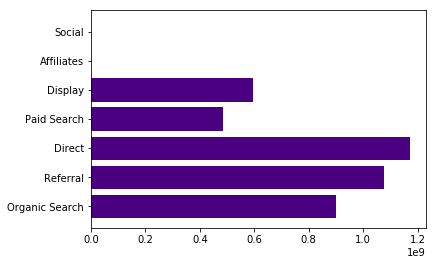

In [21]:
plt.barh(X['channelGrouping'],y2,color='indigo')

<BarContainer object of 20000 artists>

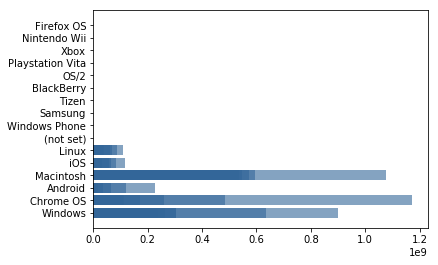

In [22]:
plt.barh(X['operatingSystem'],y2,color=(0.2, 0.4, 0.6, 0.6))

<BarContainer object of 20000 artists>

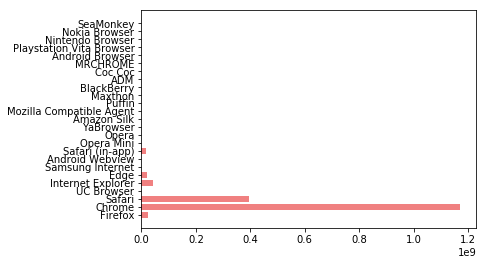

In [23]:
plt.barh(X['browser'],y2,color='lightcoral')

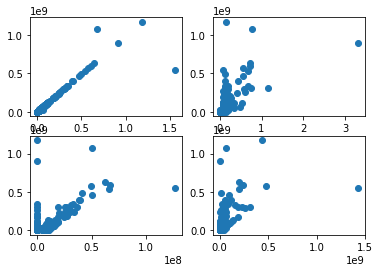

In [24]:
fig,axes= plt.subplots(2, 2)
x=X['transactionRevenue']
axes[0,0].scatter(x,y2)
x=X['transactionShipping']
axes[0,1].scatter(x,y2)
x=X['transactionTax']
axes[1,0].scatter(x,y2)
x=X['productRevenue']
axes[1,1].scatter(x,y2)

In [25]:
X=pd.get_dummies(X,drop_first=True)

In [26]:
X.shape

(20000, 691)

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#### Classification Tasks

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

model = RandomForestClassifier(n_estimators=100)
model.fit(X_train,y_train)
y_pred = model.predict(X)         

In [29]:
X.shape

(20000, 691)

In [30]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


print(classification_report(y,y_pred))
accuracy_score(y,y_pred)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     19807
          1       1.00      1.00      1.00       193

avg / total       1.00      1.00      1.00     20000



1.0

In [31]:
X4=X1.copy()
X4=X1[X1['classification']==0]

In [32]:
pd.Series(y).value_counts()

0    19807
1      193
Name: classification, dtype: int64

#### Regression Task

In [33]:
X2=X1.copy()
X2=X1[X1['classification']!=0]
y2=X2['totals_transactionRevenue']
X3=X2.drop(['totals_transactionRevenue','fullVisitorId','visitId','date','visitStartTime',
           'visitNumber','totals_sessionQualityDim','index','totals_bounces','subContinent','continent','metro'
          ,'country','socialEngagementType','city','keyword','value','region','referralPath','networkDomain',
           'campaign','adContent','classification'],axis=1)
X3=pd.get_dummies(X3,drop_first=True)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X3 = scaler.fit_transform(X3)




In [34]:
X3.shape

(193, 578)

In [35]:
from sklearn.metrics import regression,r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X3, y2, test_size=0.20, random_state=42)

model = RandomForestRegressor(max_depth= 4,n_estimators= 300)
model.fit(X_train,y_train)
y_pred = model.predict(X3)
print(mean_squared_error(y2,y_pred))
print(np.sqrt(mean_squared_error(y2,y_pred)))
print("R2: ",r2_score(y2,y_pred))

3877467493991464.5
62269314.22451563
R2:  0.8670050646684095


In [36]:
id = list(X2.index)

In [37]:
classification = pd.DataFrame(y_pred,columns=['clasifications'])

In [38]:
classification.index = id

In [39]:
X2=X2.merge(classification, right_index=True, left_index=True)

In [40]:
X2

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,totals_bounces,totals_hits,totals_newVisits,...,keyword,referralPath,isTrueDirect,adContent,transactionTax,transactionRevenue,transactionShipping,productRevenue,classification,clasifications
433,Organic Search,20171016,9549826748224805897,Not Socially Engaged,1508200705,4,1508200705,0.0,9,0.0,...,(not provided),0,True,0,3880000,17190000,8000000,17190000,1,1.265586e+07
550,Referral,20171016,3700714855829972615,Not Socially Engaged,1508192636,11,1508192636,0.0,15,0.0,...,0,/,0,0,6000000,13000000,11500000,13000000,1,1.251363e+07
555,Organic Search,20171016,1572225825161580042,Not Socially Engaged,1508162218,6,1508162218,0.0,15,0.0,...,(not provided),0,True,0,13860000,65300000,14000000,49166666,1,5.444771e+07
597,Referral,20171016,7187192533100162289,Not Socially Engaged,1508189401,17,1508189401,0.0,18,0.0,...,0,/,True,0,9210000,25230000,13000000,11100000,1,2.133377e+07
619,Referral,20171016,7889233516776348524,Not Socially Engaged,1508190484,1,1508190484,0.0,21,1.0,...,0,/,0,0,5620000,16310000,10000000,16310000,1,1.261357e+07
634,Referral,20171016,1061090985384136368,Not Socially Engaged,1508175834,2,1508175834,0.0,23,0.0,...,0,/,True,0,11510000,51000000,13000000,51000000,1,4.572670e+07
650,Organic Search,20171016,4716737341148415941,Not Socially Engaged,1508185536,1,1508185536,0.0,25,1.0,...,(not provided),0,0,0,7850000,46000000,10000000,11500000,1,4.520149e+07
654,Referral,20171016,8530613607503742741,Not Socially Engaged,1508193456,1,1508193456,0.0,27,1.0,...,0,/,0,0,9050000,22980000,13000000,5890000,1,1.326052e+07
657,Referral,20171016,852373578529854535,Not Socially Engaged,1508166186,1,1508166186,0.0,28,1.0,...,0,/,0,0,7070000,44940000,8500000,34460000,1,4.507581e+07
659,Organic Search,20171016,1617947618176891753,Not Socially Engaged,1508172563,1,1508172563,0.0,28,1.0,...,(not provided),0,0,0,0,16690000,12000000,7990000,1,1.261357e+07


In [41]:
X2.drop('classification',axis = 1,inplace=True)

In [42]:
X2

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,totals_bounces,totals_hits,totals_newVisits,...,medium,keyword,referralPath,isTrueDirect,adContent,transactionTax,transactionRevenue,transactionShipping,productRevenue,clasifications
433,Organic Search,20171016,9549826748224805897,Not Socially Engaged,1508200705,4,1508200705,0.0,9,0.0,...,organic,(not provided),0,True,0,3880000,17190000,8000000,17190000,1.265586e+07
550,Referral,20171016,3700714855829972615,Not Socially Engaged,1508192636,11,1508192636,0.0,15,0.0,...,(none),0,/,0,0,6000000,13000000,11500000,13000000,1.251363e+07
555,Organic Search,20171016,1572225825161580042,Not Socially Engaged,1508162218,6,1508162218,0.0,15,0.0,...,organic,(not provided),0,True,0,13860000,65300000,14000000,49166666,5.444771e+07
597,Referral,20171016,7187192533100162289,Not Socially Engaged,1508189401,17,1508189401,0.0,18,0.0,...,(none),0,/,True,0,9210000,25230000,13000000,11100000,2.133377e+07
619,Referral,20171016,7889233516776348524,Not Socially Engaged,1508190484,1,1508190484,0.0,21,1.0,...,(none),0,/,0,0,5620000,16310000,10000000,16310000,1.261357e+07
634,Referral,20171016,1061090985384136368,Not Socially Engaged,1508175834,2,1508175834,0.0,23,0.0,...,(none),0,/,True,0,11510000,51000000,13000000,51000000,4.572670e+07
650,Organic Search,20171016,4716737341148415941,Not Socially Engaged,1508185536,1,1508185536,0.0,25,1.0,...,organic,(not provided),0,0,0,7850000,46000000,10000000,11500000,4.520149e+07
654,Referral,20171016,8530613607503742741,Not Socially Engaged,1508193456,1,1508193456,0.0,27,1.0,...,(none),0,/,0,0,9050000,22980000,13000000,5890000,1.326052e+07
657,Referral,20171016,852373578529854535,Not Socially Engaged,1508166186,1,1508166186,0.0,28,1.0,...,(none),0,/,0,0,7070000,44940000,8500000,34460000,4.507581e+07
659,Organic Search,20171016,1617947618176891753,Not Socially Engaged,1508172563,1,1508172563,0.0,28,1.0,...,organic,(not provided),0,0,0,0,16690000,12000000,7990000,1.261357e+07


In [43]:
X2.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'socialEngagementType',
       'visitId', 'visitNumber', 'visitStartTime', 'totals_bounces',
       'totals_hits', 'totals_newVisits', 'totals_pageviews',
       'totals_sessionQualityDim', 'totals_timeOnSite',
       'totals_totalTransactionRevenue', 'totals_transactionRevenue',
       'totals_transactions', 'totals_visits', 'index', 'value',
       'deviceCategory', 'operatingSystem', 'browser', 'isMobile', 'metro',
       'subContinent', 'continent', 'region', 'city', 'networkDomain',
       'country', 'campaign', 'source', 'medium', 'keyword', 'referralPath',
       'isTrueDirect', 'adContent', 'transactionTax', 'transactionRevenue',
       'transactionShipping', 'productRevenue', 'clasifications'],
      dtype='object')

In [44]:
X4['clasifications'] = np.nan
X4.columns

D:\UTD\sem 3\python\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Index(['channelGrouping', 'date', 'fullVisitorId', 'socialEngagementType',
       'visitId', 'visitNumber', 'visitStartTime', 'totals_bounces',
       'totals_hits', 'totals_newVisits', 'totals_pageviews',
       'totals_sessionQualityDim', 'totals_timeOnSite',
       'totals_totalTransactionRevenue', 'totals_transactionRevenue',
       'totals_transactions', 'totals_visits', 'index', 'value',
       'deviceCategory', 'operatingSystem', 'browser', 'isMobile', 'metro',
       'subContinent', 'continent', 'region', 'city', 'networkDomain',
       'country', 'campaign', 'source', 'medium', 'keyword', 'referralPath',
       'isTrueDirect', 'adContent', 'transactionTax', 'transactionRevenue',
       'transactionShipping', 'productRevenue', 'classification',
       'clasifications'],
      dtype='object')

#### Concating two columns 

In [45]:
X5 = pd.concat([X2,X4],axis=0)

D:\UTD\sem 3\python\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False




In [46]:
X5.columns

Index(['adContent', 'browser', 'campaign', 'channelGrouping', 'city',
       'clasifications', 'classification', 'continent', 'country', 'date',
       'deviceCategory', 'fullVisitorId', 'index', 'isMobile', 'isTrueDirect',
       'keyword', 'medium', 'metro', 'networkDomain', 'operatingSystem',
       'productRevenue', 'referralPath', 'region', 'socialEngagementType',
       'source', 'subContinent', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_pageviews', 'totals_sessionQualityDim',
       'totals_timeOnSite', 'totals_totalTransactionRevenue',
       'totals_transactionRevenue', 'totals_transactions', 'totals_visits',
       'transactionRevenue', 'transactionShipping', 'transactionTax', 'value',
       'visitId', 'visitNumber', 'visitStartTime'],
      dtype='object')

In [47]:
X5.fillna(0,inplace=True)

In [48]:
X6 = X5.copy()

#### Final Rsquare for the given data

In [49]:
from sklearn.metrics import regression,r2_score

print(r2_score(X5['totals_transactionRevenue'],X5['clasifications']))

0.9051276699803114


# Part 2
In this part you will create a Python function ``plot_decision_boundary`` that will accepts a machine learning model, feature set ``X``, and target set ``y`` as input and will plot the decision boundary of the input machine learning model  on ``(X,y)``. The following is a sample run of this function: 

```Python
%matplotlib inline
# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

# Training a classifier
svm = SVC(C=0.5, kernel='linear')
svm.fit(X, y)

# Plotting decision boundary
plot_decision_boundary(X, y, clf=svm)

# Adding axes annotations
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.title('SVM on Iris')```

Sample output: 
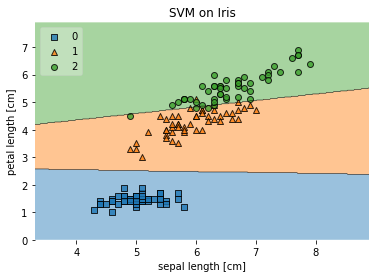

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Making the function to plot decision boundary 

In [51]:
def plot_decision_boundary(X, y, model_class, **model_params):
    reduced_data = X[:, :2]                  #reducing the feature parameters to 2 
    model = model_class(**model_params)     #applying the model with given model parameters if any are available
    model.fit(reduced_data, y)              #fitting the target values with reduced data

                                            # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02                                 # point in the mesh [x_min, m_max]x[y_min, y_max].    

                                            # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    x1, y1 = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

                                                        # Obtain labels for each point in mesh using the model.
    Z = model.predict(np.c_[x1.ravel(), y1.ravel()])    #returning the contiguous flattened array by using np.ravel() function

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    x1, y1 = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    Z = model.predict(np.c_[x1.ravel(), y1.ravel()]).reshape(x1.shape)

    plt.contourf(x1, y1, Z, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=1,edgecolors='black')
    return plt

#### for this function we only have to provide model class name with Values of X and y; it automatically reduces the values of features to 2 and plots the decision boundaries

In [52]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
cancer=load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

dec = DecisionTreeClassifier()
dec.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

<module 'matplotlib.pyplot' from 'D:\\UTD\\sem 3\\python\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

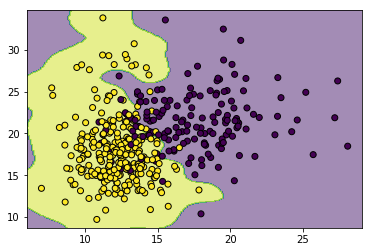

In [53]:
%matplotlib inline

plot_decision_boundary(X_train, y_train,SVC,C=2)


<module 'matplotlib.pyplot' from 'D:\\UTD\\sem 3\\python\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

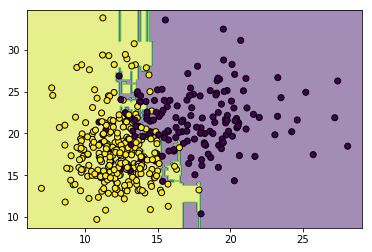

In [54]:
%matplotlib inline

plot_decision_boundary(X_train, y_train,RandomForestClassifier,n_estimators=10)

<module 'matplotlib.pyplot' from 'D:\\UTD\\sem 3\\python\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

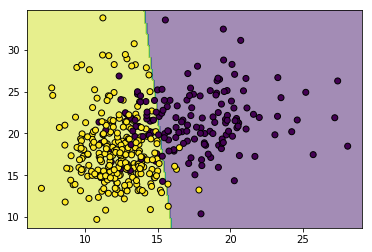

In [55]:
%matplotlib inline
plot_decision_boundary(X_train, y_train,LogisticRegression)